# Churn analysis for the gym chain "Model Fitness"

The gym chain "Model Fitness" is developing a customer interaction strategy based on analytical data. 

Let's analyze customer profiles and develop a customer retention strategy.

We should:
- Learn to predict the probability of churn (for the upcoming month) for each customer
- Draw up typical user portraits: select the most outstanding groups and describe their main features
- Analyze the factors that impact churn most
- Draw basic conclusions and develop recommendations on how to improve customer service:
    - Identify target groups
    - Suggest measures to cut churn
    - Describe any other patterns we see with respect to interaction with customers

## Contents

- [__Step 1. Download the data__](#step1)

- [__Step 2. Carry out exploratory data analysis (EDA)__](#step2)

- [__Step 3. Build a model to predict user churn__](#step3)
- [__Step 4. Create user clusters__](#step4)
- [__Step 5. Come up with conclusions and basic recommendations on working with customers__](#step5)

<a id='step1'></a>

### Step 1. Download the data

In [1]:
# import necessary modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

In [2]:
# read the data 
gym = pd.read_csv('gym_churn_us.csv')


In [3]:
# get general info
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [4]:
# read the first 5 rows
gym.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [5]:
# check 'month to end contract' contains non integer values
months = [1,2,3,4,5,6,7,8,9,10,11,12]
gym.query('Month_to_end_contract not in @months')

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn


In [6]:
# convert 'Month_to_end_contract' to int
gym['Month_to_end_contract'] = gym['Month_to_end_contract'].astype('int')

In [7]:
# check for duplicates
gym.duplicated().sum()

0

### Conclusion

- The dataset contains no missing values and duplicates.
- 'Month_to_end_contract' was converted to int

<a id='step2'></a>

### Step 2. Carry out exploratory data analysis (EDA)

Look at the dataset: 
- does it contain any missing features? 



In [8]:
# explicitly check for missing values
gym.isna().sum()

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

no missing values so far

- Study the mean values and standard deviation (use the describe() method). 


In [9]:
# check mean and std for the whole dataset
gym.describe().T.sort_index()

,count,mean,std,min,25%,50%,75%,max
Age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Avg_class_frequency_current_month,4000.0,1.767052,1.052906,0.000000,0.963003,1.719574,2.510336,6.146783
Avg_class_frequency_total,4000.0,1.879020,0.972245,0.000000,1.180875,1.832768,2.536078,6.023668
Churn,4000.0,0.265250,0.441521,0.000000,0.000000,0.000000,1.000000,1.000000
Contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
Group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
Lifetime,4000.0,3.724750,3.749267,0.000000,1.000000,3.000000,5.000000,31.000000
Month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000
Near_Location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000


### Comments:
- The average age is \~29 years with small std (~3)
- Additional charges has a big std (~96) with mean value of ~147 resulting in high variance
- Mean class frequency (current and total) is close to 2 (with std ~1) meaning more people visit the gym twice (or more) a week.
- Average contract period is 4.68 months with big std value of ~4 means that it has a high variance.  Short and long contracts are used almost equally often.
- The same is true for the 'lifetime' and 'months to end contract': mean and std are almost equal for every field.
- Group of those who stayed is almost 3 times bigger than the group of those who left.

Look at the mean feature values in two groups: for those who left (churn) and for those who stayed (use the groupby() method). 

In [10]:
#check mean and std for 2 groups: those who left and those who stayed
gym.groupby('Churn').agg(['mean','std']).stack(level=0).unstack(level=0)

mean                    std  \
Churn                                       0           1          0   
Age                                 29.976523   26.989632   3.009933   
Avg_additional_charges_total       158.445715  115.082899  99.801599   
Avg_class_frequency_current_month    2.027882    1.044546   1.018994   
Avg_class_frequency_total            2.024876    1.474995   1.016006   
Contract_period                      5.747193    1.728558   4.716942   
Group_visits                         0.464103    0.268615   0.498795   
Lifetime                             4.711807    0.990575   3.874780   
Month_to_end_contract                5.283089    1.662582   4.363522   
Near_Location                        0.873086    0.768143   0.332933   
Partner                              0.534195    0.355325   0.498914   
Phone                                0.903709    0.902922   0.295040   
Promo_friends                        0.353522    0.183789   0.478144   
gender                               0.510037    0.510839   0.499984   

                                              
Churn                                      1  
Age                                 2.895163  
Avg_additional_charges_total       77.696419  
Avg_class_frequency_current_month   0.770237  
Avg_class_frequency_total           0.694705  
Contract_period                     2.132371  
Group_visits                        0.443448  
Lifetime                            1.110799  
Month_to_end_contract               1.964593  
Near_Location                       0.422217  
Partner                             0.478837  
Phone                               0.296204  
Promo_friends                       0.387495  
gender                              0.500118

### Comments
Comparing mean values for the 2 groups we see that:
- the average age of those who left is \~3 years lower (~27 vs. ~30)
- mean additional charges for those who left is \~27% lower (~158 vs. ~115)
- mean frequency for those who left tends to once a week vs. twice a week for the retained customers
- mean contract period for those who left sufficiently lower (\~1.7 vs \~5.7) with lower std (\~2 vs. \~4.7). It means that people who leave the gym have 1 or 3 month contract while loyal customers have longer contract periods as well as short contract periods.
- the same is true for the 'lifetime' and 'months to end contract': those who left have sufficiently lower 'lifetime'(\~1 vs \~4.7)/'months to end contract'(1.7 vs. 5.3) with lower std 'lifetime'(\~1 vs. \~3.9)/'months to end contract'(\~2 vs. 4.4)
- also mean values for boolean fields such as 'Group_visits', 'Partner', 'Promo_friends', 'Near_Location' are lower for those who left.

In [11]:
#calculate group sizes
gym.groupby('Churn')['Age'].agg('count')

Churn
0    2939
1    1061
Name: Age, dtype: int64

The 2 groups are not equal (one is almost 3 times bigger than another).

- Plot bar histograms and feature distributions for those who left (churn) and those who stayed. 

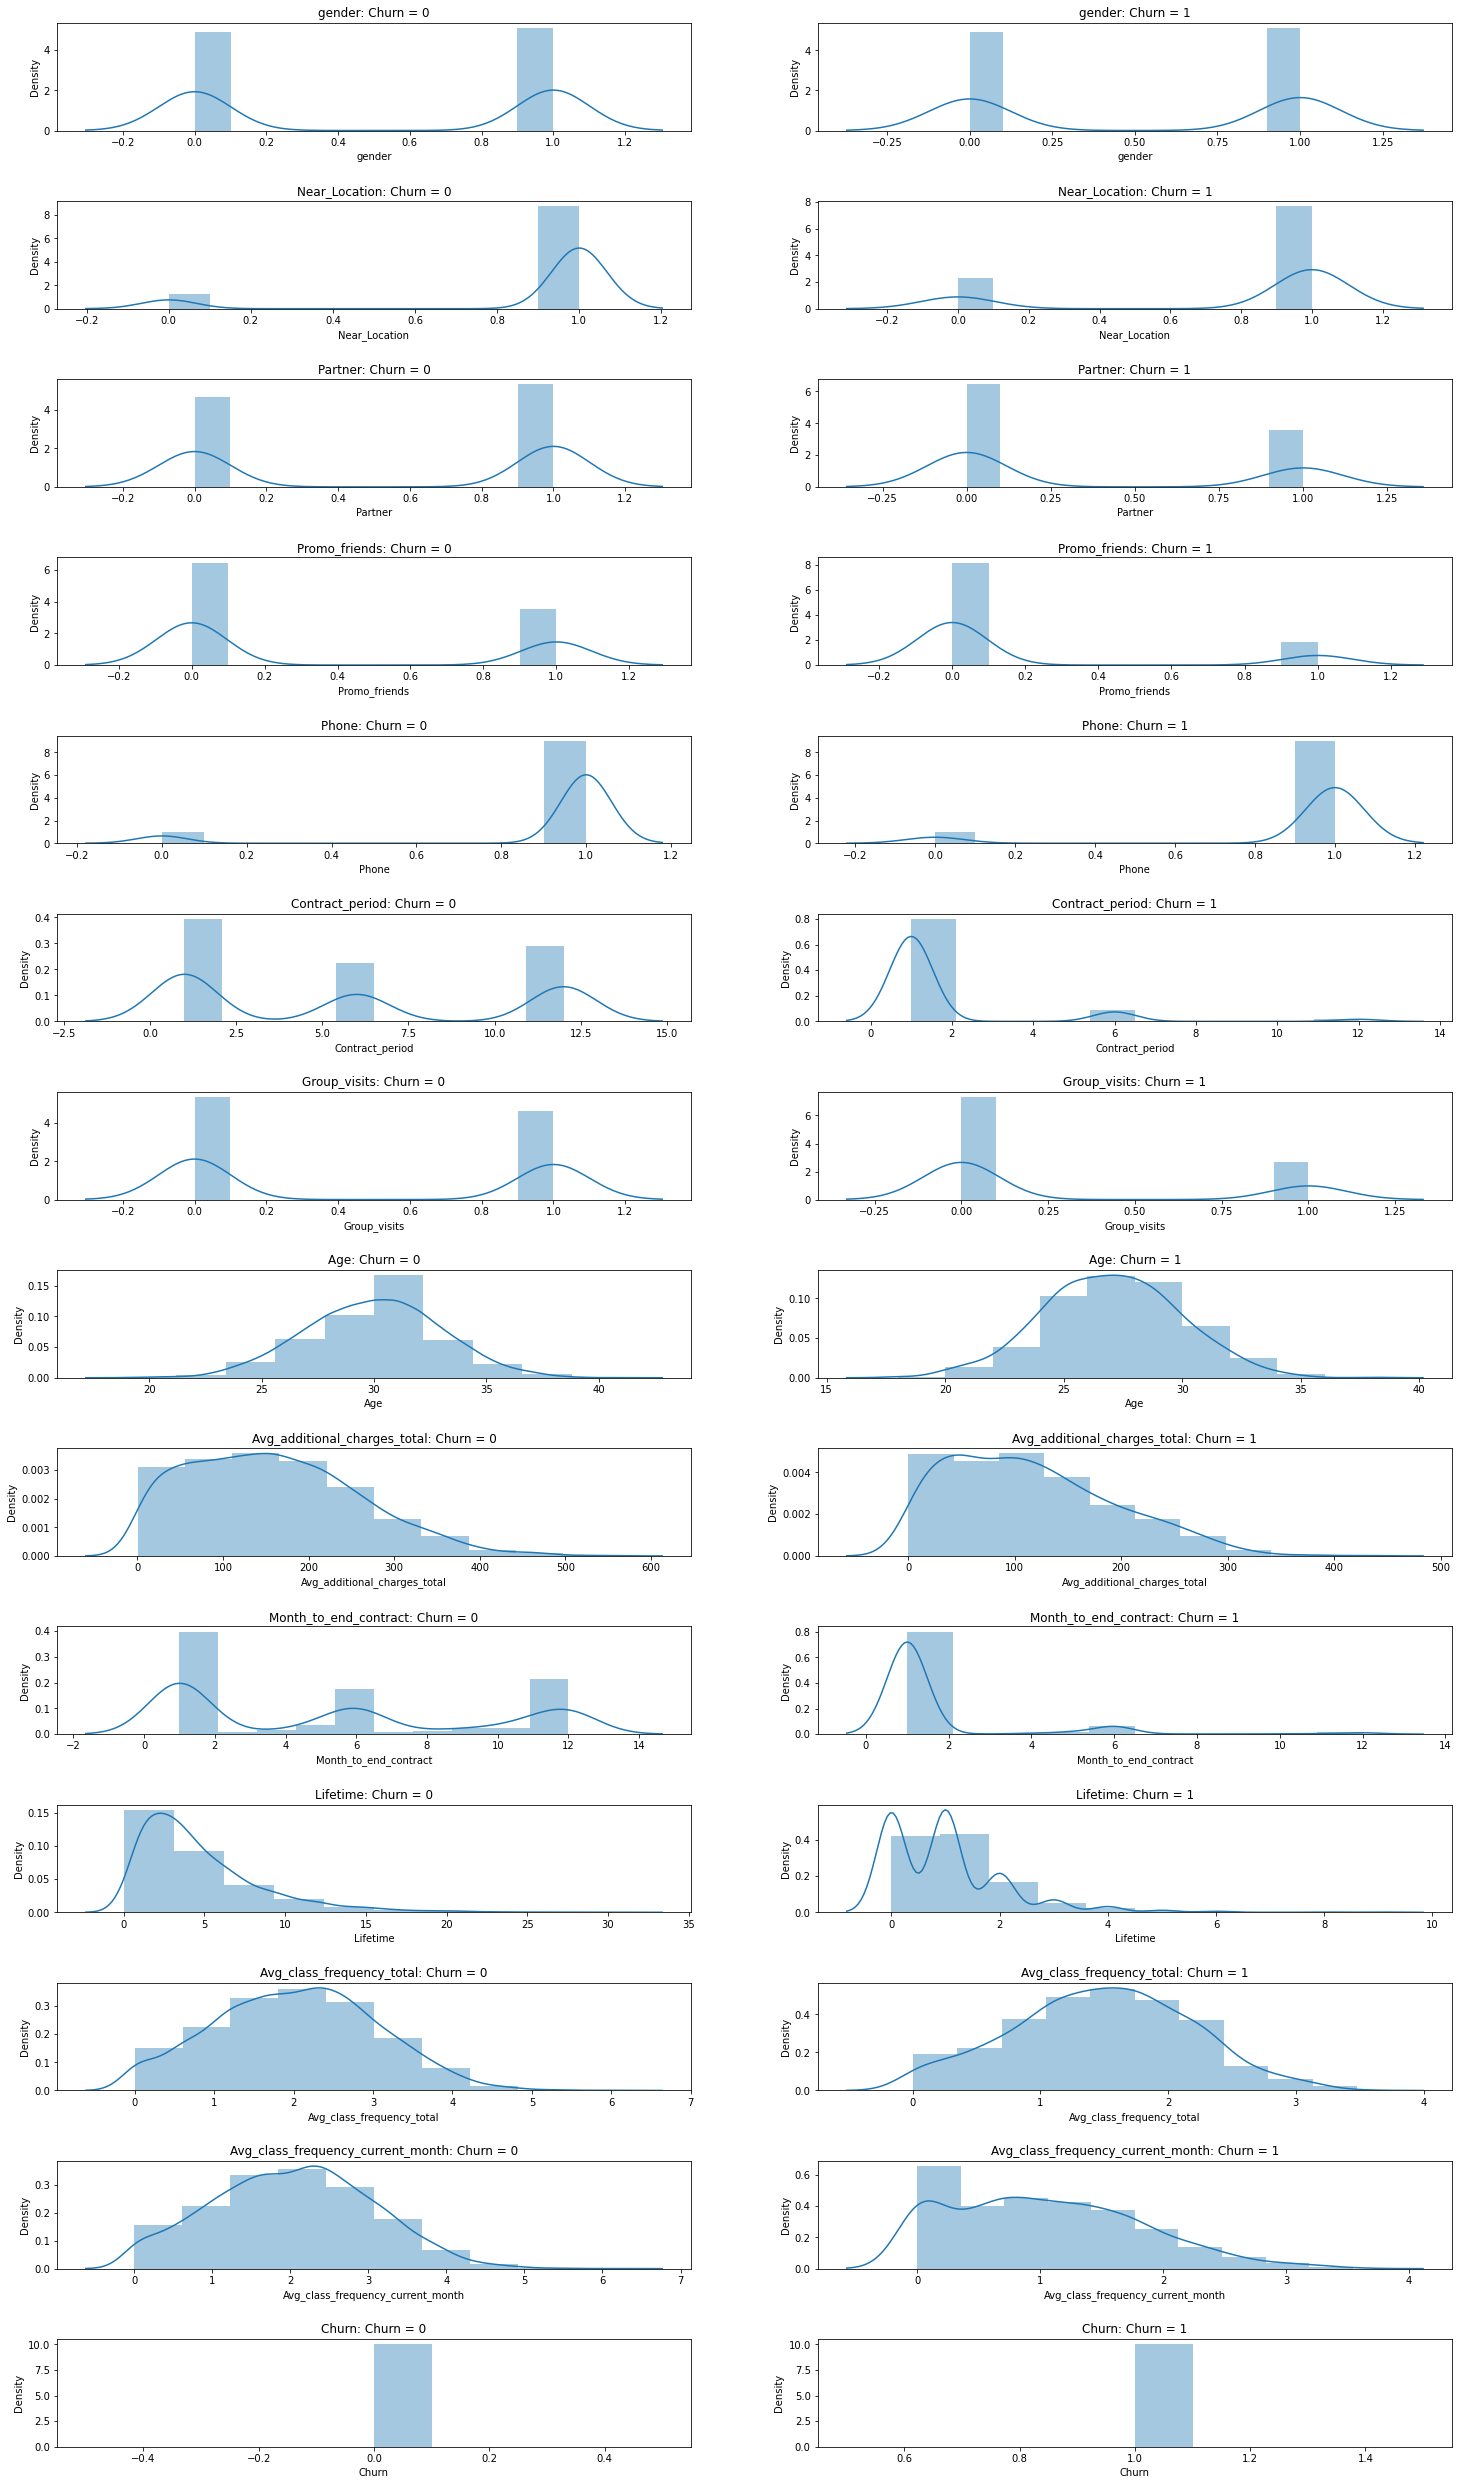

In [12]:
i=0
plt.figure(figsize=(25, 45))
for feature in gym.columns:
    ax = plt.subplot2grid((110, 13), (8*i, 0), colspan=6, rowspan=5)
    sns.distplot(gym.query('Churn==0')[feature], bins = 10, ax=ax)
    plt.title(feature + ': Churn = 0')
    ax = plt.subplot2grid((110, 13), (8*i, 7), colspan=6, rowspan=5)
    sns.distplot(gym.query('Churn==1')[feature], bins = 10, ax=ax)
    plt.title(feature + ': Churn = 1')
    i += 1
plt.show() 

### Comments
Comparing feature distributions for the 2 groups:
- There's almost no difference in distribution for: 'Gender', 'Near_Location', 'Phone'
- Those who left mainly had contract period of 1 month while those who stayed have 1, 6 and 12 months contract period. The same is true for 'month to end contract' feature 
- Those who left mainly had lifetime not more than 2 months while those who stayed had lifetime in the range up to 10 months.
- age has a distribution similar to normal  but with different mean values for both groups
- 'additional charges' feature is skewed to the right for both groups
- average frequency for the current month for those who left is mainly 0 or 1 per week while for the loyal customers it's mainly 1, 2 or 3 per week

Build a correlation matrix and display it.

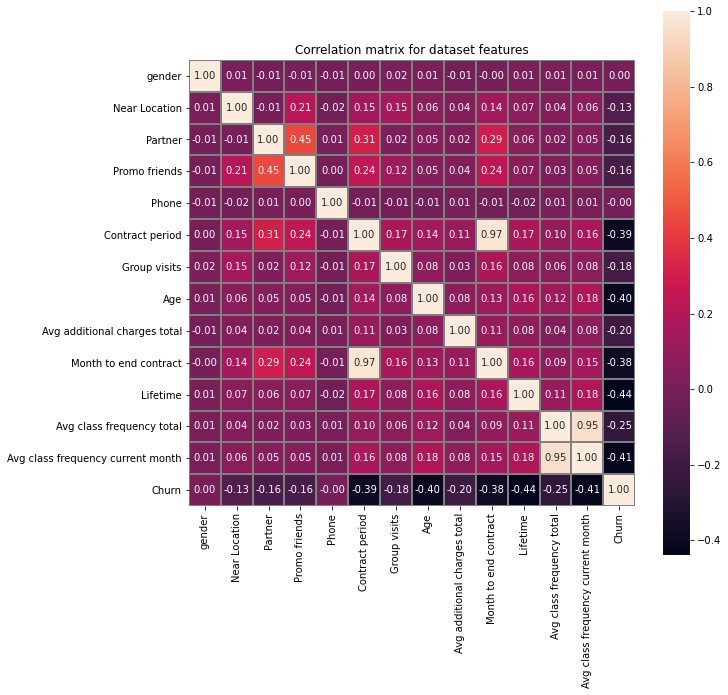

In [13]:
cm = gym.corr()
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(cm, annot = True, square=True, fmt='.2f', linewidths=1, linecolor='gray', ax=ax)
b=ax.set_title("Correlation matrix for dataset features")
# get rid of _ in labels
b=ax.set_xticklabels(
    [a.get_text().replace('_',' ') for a in ax.get_xticklabels()])
b=ax.set_yticklabels(
    [a.get_text().replace('_',' ') for a in ax.get_xticklabels()])

### Comments

- The following features are highly correlated  (with positive correlation):    
    - 'Month to end contract' and 'contract period'
    - 'Average frequency for the current month' and 'Average frequency total'

- There's a medium positive correlation for 'Promo_firends' and 'Partner' features
- There's a medium negative correlation for the 'Churn' and :
    - Age
    - Contract period
    - Lifetime
    - Month to end contract
    - Avg class frequency current month

### Conclusions

- The dataset has no missing values
- The average age is \~29 years with small std (~3)
- Additional charges has a big std (~96) with mean value of ~147 resulting in high variance
- Mean class frequency (current and total) is close to 2 (with std ~1) meaning more people visit the gym twice (or more) a week.
- Average contract period is 4.68 months with big std value of ~4 means that it has a high variance.  Short and long contracts are used almost equally often.
- The same is true for the 'lifetime' and 'months to end contract': mean and std are almost equal for every field.
- Group of those who stayed is almost 3 times bigger than the group of those who left.
- Comparing mean values for the 2 groups we see that:
    - the average age of those who left is \~3 years lower (~27 vs. ~30)
    - mean additional charges for those who left is \~27% lower (~158 vs. ~115)
    - mean frequency for those who left tends to once a week vs. twice a week for the retained customers
    - mean contract period for those who left sufficiently lower (\~1.7 vs \~5.7) with lower std (\~2 vs. \~4.7). It means that people who leave the gym have 1 or 3 month contract while loyal customers have longer contract periods as well as short contract periods.
    - the same is true for the 'lifetime' and 'months to end contract': those who left have sufficiently lower 'lifetime'(\~1 vs \~4.7)/'months to end contract'(1.7 vs. 5.3) with lower std 'lifetime'(\~1 vs. \~3.9)/'months to end contract'(\~2 vs. 4.4)
    - also mean values for boolean fields such as 'Group_visits', 'Partner', 'Promo_friends', 'Near_Location' are lower for those who left.
    
- Comparing feature distributions for the 2 groups:
     - There's almost no difference in distribution for: 'Gender', 'Near_Location', 'Phone'
     - Those who left mainly had contract period of 1 month while those who stayed have 1, 6 and 12 months contract period. The same is true for 'month to end contract' feature 
     - Those who left mainly had lifetime not more than 2 months while those who stayed had lifetime in the range up to 10 months.
     - age has a distribution similar to normal  but with different mean values for both groups
     - 'additional charges' feature is skewed to the right for both groups
     - average frequency for the current month for those who left is mainly 0 or 1 per week while for the loyal customers it's mainly 1, 2 or 3 per week
     
- The following features are highly correlated  (with positive correlation):    
    - 'Month to end contract' and 'contract period'
    - 'Average frequency for the current month' and 'Average frequency total'

- There's a medium positive correlation for 'Promo_firends' and 'Partner' features
- There's a medium negative correlation for the 'Churn' and :
    - Age
    - Contract period
    - Lifetime
    - Month to end contract
    - Avg class frequency current month

<a id='step3'></a>

### Step 3. Build a model to predict user churn. 


Build a binary classification model for customers where the target feature is the user's leaving next month.


- Divide the data into train and validation sets using the train_test_split() function. 

In [14]:
# select features X and target variable y
X = gym.drop('Churn',axis=1)
y = gym['Churn']
# divide the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)

- Train the model on the train set with two methods:

      logistic regression
      random forest

In [15]:
# define the algorithm for the logistic regression model
lr_model = LogisticRegression(random_state=0)

# train the LR model
lr_model.fit(X_train, y_train)
# use the trained LR model to make predictions
lr_predictions = lr_model.predict(X_test)
lr_probabilities = lr_model.predict_proba(X_test)[:,1]

In [16]:
# define the algorithm for the random forest model
rf_model = RandomForestClassifier(n_estimators = 100,random_state=0)

# train the random forest model
rf_model.fit(X_train, y_train)
# use the trained model to make predictions
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:,1]

- Evaluate accuracy, precision, and recall for both models using the validation data. Use them to compare the models. Which model gave better results?

In [17]:
# define the function that will output our metrics
def print_all_metrics(y_true, y_pred, y_proba, title = 'Classification metrics'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

In [18]:
# print all metrics for both models
print_all_metrics(y_test, lr_predictions, lr_probabilities , title='Metrics for logistic regression:')
print_all_metrics(y_test, rf_predictions, rf_probabilities, title = 'Metrics for random forest:')


Metrics for logistic regression:
	Accuracy: 0.93
	Precision: 0.86
	Recall: 0.83
	F1: 0.85
	ROC_AUC: 0.97
Metrics for random forest:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.82
	F1: 0.83
	ROC_AUC: 0.97


According to precision/recall/f1 scores logistic regression is slightly better though random forest model is also good.

We can't rely on accuracy for the unbalanced datasets (here it's the case).

In [19]:
# get importance of the features for random forest model
print('Feature importance:\n\n', "\n".join([str((col, imp)) for (col, imp) in sorted(zip(X.columns ,rf_model.feature_importances_), key=lambda x: x[1], reverse=True)]))

# get feature weights for linear regression
feature_weights = lr_model.coef_.reshape([13, ])
print('\nWeights are:\n\n', "\n".join([str((col, imp)) for (col, imp) in sorted(zip(X.columns ,feature_weights ), key=lambda x: abs(x[1]), reverse=True)]))

Feature importance:

 ('Lifetime', 0.2764994888257982)
('Avg_class_frequency_current_month', 0.18016975204132626)
('Avg_class_frequency_total', 0.12988273724611252)
('Age', 0.11912869210821361)
('Avg_additional_charges_total', 0.09147294473613203)
('Month_to_end_contract', 0.06885504424152025)
('Contract_period', 0.06596372225955066)
('Group_visits', 0.01565161157911574)
('gender', 0.01242526225532823)
('Partner', 0.012284546136319043)
('Promo_friends', 0.012053446365513112)
('Near_Location', 0.009420850836259953)
('Phone', 0.006191901368810342)

Weights are:

 ('Avg_class_frequency_current_month', -4.161979491636506)
('Avg_class_frequency_total', 3.4708495234547456)
('Lifetime', -0.9728736891638342)
('Group_visits', -0.7127427390580288)
('Phone', 0.6113010702251136)
('Promo_friends', -0.5684335956076787)
('Contract_period', -0.18896923420111453)
('Age', -0.18196326348516764)
('Month_to_end_contract', -0.0669398068282107)
('Near_Location', 0.05297584159580415)
('Partner', -0.0484390298

From random forest model we've got the following important features:
- Lifetime
- Avg_class_frequency_current_month
- Avg_class_frequency_total
- Age
- Avg_additional_charges_total
- Month_to_end_contract
- Contract_period

But logistic regression gave us strange results due to multi-collinearity issue.
We need apply L1 regularization to get rid of correlated features.
So let's redo Logistic regression but with L1 regularization.

In [20]:
# we need to scale features to apply regularization
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# define the algorithm for the logistic regression model with L1-regularization
lr_model = LogisticRegression(penalty='l1',C=.01, solver='liblinear', random_state=0)

# train the LR model
lr_model.fit(X_train_st, y_train)
# use the trained LR model to make predictions
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

In [21]:
print_all_metrics(y_test, lr_predictions, lr_probabilities , title='Metrics for logistic regression:')

Metrics for logistic regression:
	Accuracy: 0.90
	Precision: 0.81
	Recall: 0.80
	F1: 0.80
	ROC_AUC: 0.96


In [22]:
# get feature weights for linear regression
feature_weights = lr_model.coef_.reshape([13, ])
print('\nWeights are:\n\n', "\n".join([str((col, imp)) for (col, imp) in sorted(zip(X.columns ,feature_weights ), key=lambda x: abs(x[1]), reverse=True)]))


Weights are:

 ('Lifetime', -1.1916394512814295)
('Avg_class_frequency_current_month', -0.6221001933796262)
('Contract_period', -0.567448088591252)
('Age', -0.5362258969732062)
('Avg_additional_charges_total', -0.1426167744703754)
('Month_to_end_contract', -0.04747885050145353)
('Group_visits', -0.03844891775173211)
('gender', 0.0)
('Near_Location', 0.0)
('Partner', 0.0)
('Promo_friends', 0.0)
('Phone', 0.0)
('Avg_class_frequency_total', 0.0)


This time we've got the following important features:
- Lifetime
- Avg_class_frequency_current_month (Avg_class_frequency_total received 0 weight)
- Contract_period (Month_to_end_contract weight is almost 0)
- Age
- Avg_additional_charges_total

At the same time the model quality became a bit worse.

### Conclusions

According to precision/recall/f1 scores logistic regression (without L1 regularization) is slightly better though random forest model is also good.


We can't rely on accuracy for the unbalanced datasets (here it's the case).

The models resulted in the following important features:
- Lifetime
- Avg_class_frequency_current_month
- Avg_class_frequency_total
- Age
- Avg_additional_charges_total
- Month_to_end_contract
- Contract_period

This corresponds to our conclusions in step 2 regarding correlation between the target variable and features.

<a id='step4'></a>

### Step 4. Create user clusters

Set aside the column with data on churn and identify object (user) clusters:

- Standardize the data. 

In [23]:
# train StandardScaler and transform dataset
scaler = StandardScaler()
X_st = scaler.fit_transform(X)

- Use the linkage() function to build a matrix of distances based on the standardized feature matrix and plot a dendrogram. 

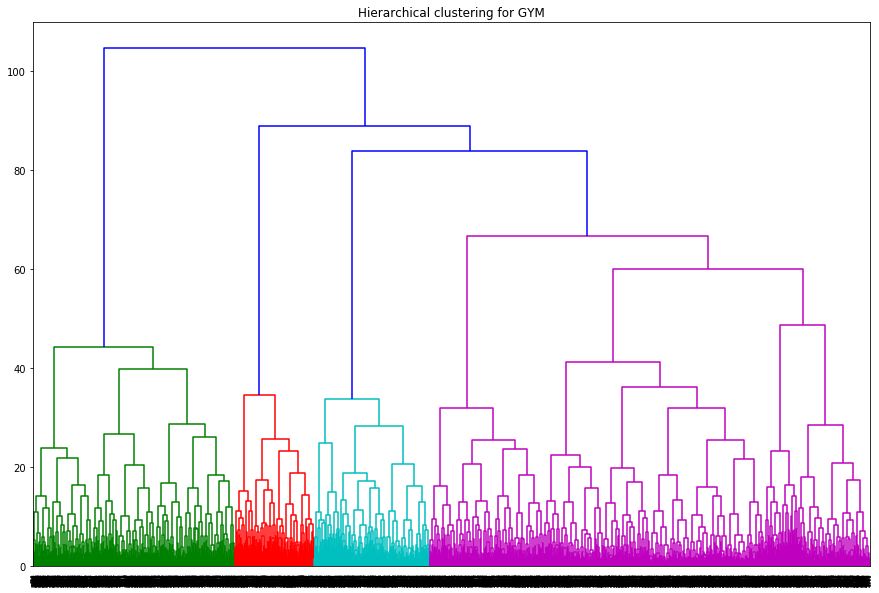

In [24]:
# get the standardized feature matrix
linked = linkage(X_st, method = 'ward') 
# plot a dendrogram
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchical clustering for GYM')
plt.show() 

Purple cluster looks big enough to split it into 2 different clusters.

- Train the clustering model with the K-means algorithm and predict customer clusters. (Let the number of clusters be n=5) 

In [25]:
# setting the number of clusters as 5
km = KMeans(n_clusters = 5, random_state=0) 
# applying the algorithm to the data and forming a cluster vector 
labels = km.fit_predict(X_st) 

- Look at the mean feature values for clusters. Does anything catch your eye?

In [26]:
# Calculate mean feature values
gym['labels'] = labels
gym.groupby('labels').agg(['mean']).stack(level=0).unstack(level=0)

mean                          \
labels                                      0           1           2   
gender                               0.502473    0.522078    0.495050   
Near_Location                        0.959446    0.862338    0.000000   
Partner                              0.783383    0.470130    0.463366   
Promo_friends                        0.574679    0.306494    0.079208   
Phone                                1.000000    0.000000    1.000000   
Contract_period                     10.884273    4.787013    2.352475   
Group_visits                         0.543027    0.425974    0.215842   
Age                                 29.980218   29.301299   28.477228   
Avg_additional_charges_total       160.706969  143.957664  135.457501   
Month_to_end_contract                9.950544    4.475325    2.198020   
Lifetime                             4.738872    3.924675    2.809901   
Avg_class_frequency_total            1.983305    1.847220    1.660461   
Avg_class_frequency_current_month    1.976225    1.716369    1.477324   
Churn                                0.027695    0.267532    0.443564   

                                                           
labels                                      3           4  
gender                               0.485737    0.560335  
Near_Location                        1.000000    0.976105  
Partner                              0.350238    0.356033  
Promo_friends                        0.240095    0.229391  
Phone                                1.000000    0.998805  
Contract_period                      1.948494    2.665472  
Group_visits                         0.341521    0.473118  
Age                                 28.167987   30.127838  
Avg_additional_charges_total       131.622204  161.724258  
Month_to_end_contract                1.856577    2.455197  
Lifetime                             2.440571    4.896057  
Avg_class_frequency_total            1.247634    2.851531  
Avg_class_frequency_current_month    1.012983    2.849473  
Churn                                0.514263    0.068100

### Conclusions

- We see that clusters 2 and 3 more likely to have left customers than others. They have the lowest values for 
    - average frequency 
    - lifetime
    - month to end contract
    - contract period
    - additional charges
    - age
    - group visits

- Cluster 1 customers didn't provide phone while all other clusters customers did.
- All cluster 2 customers live far from gym while the others (the largest part) live near it.


- Plot distributions of features for the clusters. Do you notice anything? 

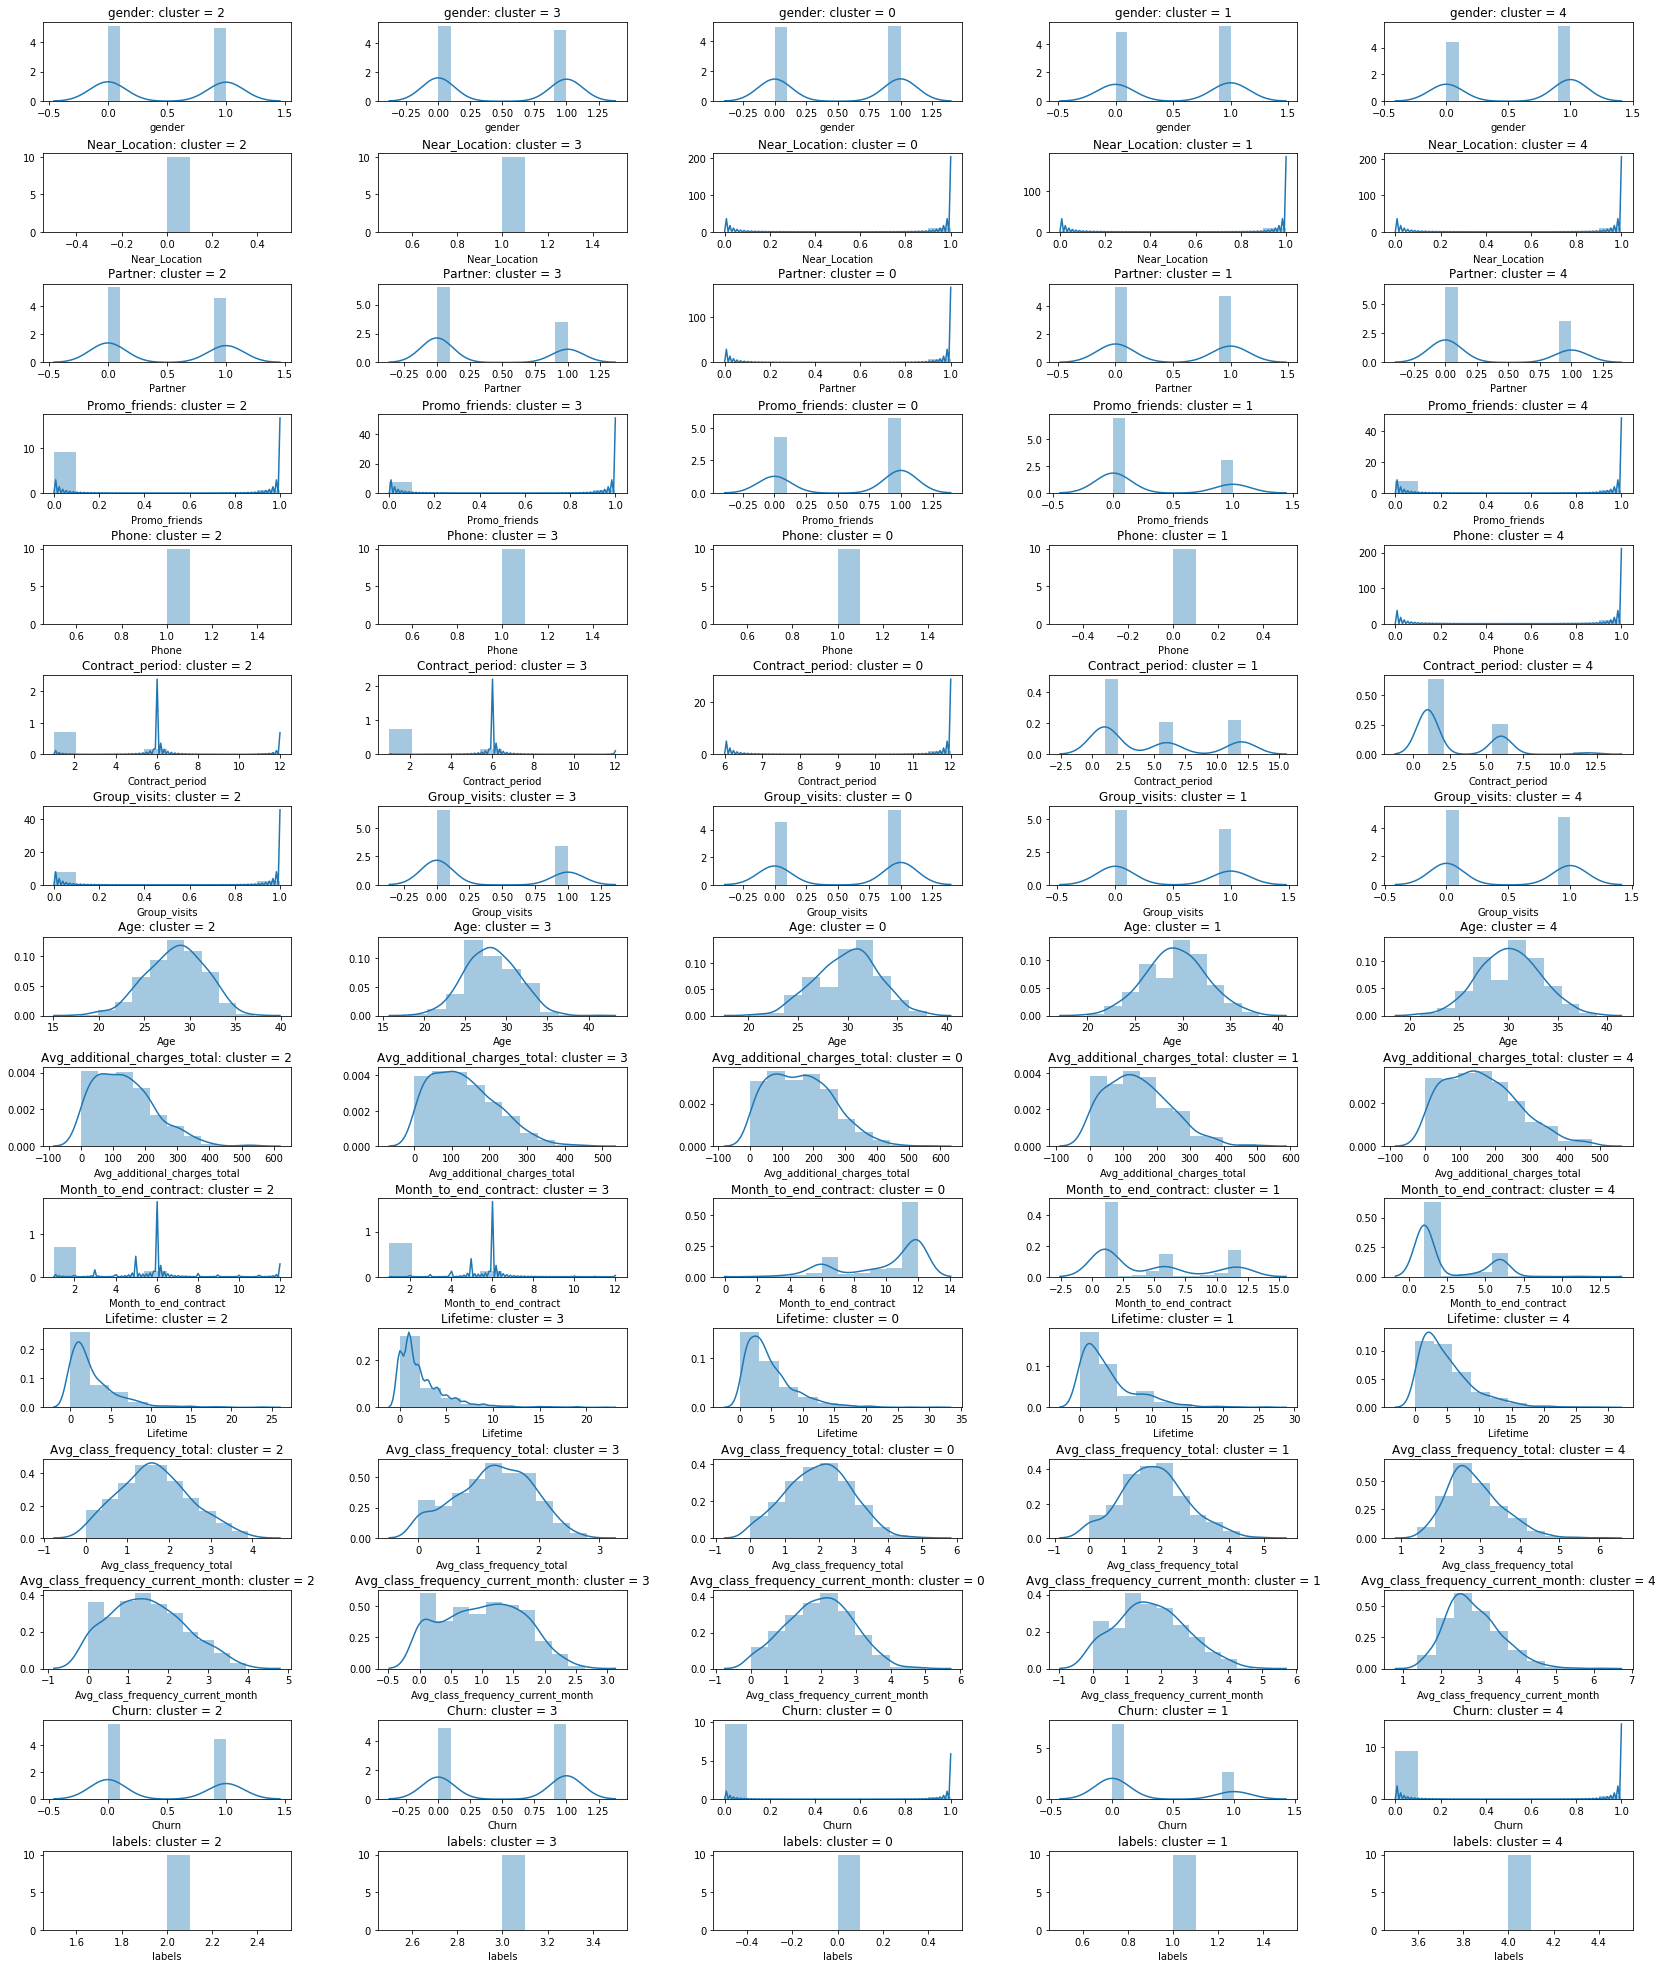

In [27]:
i=0
plt.figure(figsize=(30, 45))
for feature in gym.columns:
    
    ax = plt.subplot2grid((150, 100), (8*i, 0), colspan=15, rowspan=5)
    sns.distplot(gym.query('labels==2')[feature], bins = 10, ax=ax)
    plt.title(feature + ': cluster = 2')
    ax = plt.subplot2grid((150, 100), (8*i, 20), colspan=15, rowspan=5)
    sns.distplot(gym.query('labels==3')[feature], bins = 10, ax=ax)
    plt.title(feature + ': cluster = 3')
    ax = plt.subplot2grid((150, 100), (8*i, 40), colspan=15, rowspan=5)
    sns.distplot(gym.query('labels==0')[feature], bins = 10, ax=ax)
    plt.title(feature + ': cluster = 0')
    ax = plt.subplot2grid((150, 100), (8*i, 60), colspan=15, rowspan=5)
    sns.distplot(gym.query('labels==1')[feature], bins = 10, ax=ax)
    plt.title(feature + ': cluster = 1')
    ax = plt.subplot2grid((150, 100), (8*i, 80), colspan=15, rowspan=5)
    sns.distplot(gym.query('labels==4')[feature], bins = 10, ax=ax)
    plt.title(feature + ': cluster = 4')    
    i += 1
plt.show() 

The distribution for clusters 2 and 3 is different from other clusters for the following features:
- Near location: all cluster 2 customers live far from the gym, all cluster 3 customers live near the gym. In the other clusters customers are distributed between far and near locations.
- Contract period and month to end contract for clusters 2 and 3 is mainly represented by the period of 1 month while other clusters have longer periods in comparable quantity.
- Age for clusters 2 and 3 is centered around value below 30 while other clusters distributions have centers at 30 and above.
- Lifetime distributions for clusters 0,1,4 have longer tails compared to clusters 2 and 3.
- Frequency distributions for clusters 2 and 3 are centered at ~1.5 while other clusters' distributions are centered at 2 and above.

- Calculate the churn rate for each cluster (use the groupby() method).

In [28]:
# We already calculated the churn rate above when we calculated mean feature values (+ target mean) 
# Let's recalculate
gym.groupby('labels')['Churn'].sum()/gym.groupby('labels')['Churn'].count()

labels
0    0.027695
1    0.267532
2    0.443564
3    0.514263
4    0.068100
Name: Churn, dtype: float64

- Do they differ in terms of churn rate? Which clusters are prone to leaving, and which are loyal?

Clusters 2 and 3 are prone to leaving while clusters 0 and 4 are loyal.
Cluster 1 is mainly loyal though it has 26% of those who left.

### Conclusions

- We've build 5 clusters for the gym customers
- Clusters 2 and 3 are more prone to leaving than others while clusters 0 and 4 are loyal. Cluster 1 mainly loyal though it has a portion of those who left.
- Clusters 2 and 3 are characterized by shorter contract periods (\~1 month), month to end contract (\~1 month) and lifetime. Typically customers from clusters 2 and 3 make visits once a week as opposed to customers from other clusters who make visits typically twice a week.
- Clusters 2 and 3 have on average younger customers compared to other clusters.

<a id='step5'></a>

### Step 5. Conclusions and basic recommendations on working with customers


### Conclusions

- Churn depends on the following main factors (less the factor values higher the probability of churn):
    - Lifetime
    - Avg_class_frequency_current_month
    - Avg_class_frequency_total
    - Age
    - Avg_additional_charges_total
    - Month_to_end_contract
    - Contract_period
- We've identified 5 clusters for customers and 2 of them are prone to churn.
- The 'churn' clusters are typically represented by younger customers (27 yo) with shorter contracts (usually 1 month) and shorter lifetime (1 month) visiting the gym once a week.

### Recommendations
- We should target the marketing campaigns to younger people (on average 27 yo).
- As mainly churn occurs among people who just started visiting the gym (lifetime on average is 1 month) it's recommended to make special offers for the beginners, e.g. 50% discount for 6 month contract after expiry of the first 1 month contract.
- Other offers that might increase the visit frequency and involvement can be implemented, e.g. free group training or free swimming pool during the 1st 2 months.